# Image Invariances and Assymetric feature matching


In our previous notebook, we saw that patch matching was complicated by self-similar appearances, viewpoint and lighting variation. Models that can work across all these variations are often called invariant. In earlier work on computer vision, a lot of work was conducted to build image patch descriptors that are invariant to these variations, for example the [Scale Invariant Feature Transform (SIFT)](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html). More recently, it is common to use image descriptors learned by deep learning approaches for matching. 

Today though, we will explore a fast tree-based method for patch matching, that is particularly popular in visual odometry, where we use keypoints detected in multiple frames to infer how a camera has moved.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from IPython import display

In [2]:
# Let's load in our two drone images again
im_1 = cv2.cvtColor(cv2.resize(cv2.imread('./test_images/Drone_1.jpg'),(400,400)), cv2.COLOR_BGR2GRAY)
im_2 = cv2.cvtColor(cv2.resize(cv2.imread('./test_images/Drone_2.jpg'),(400,400)), cv2.COLOR_BGR2GRAY)

In [3]:
# We'll grab some Harris corners
harris_1 = cv2.cornerHarris(im_1,blockSize=2,ksize=3,k=0.04)
kp_1 = harris_1 > 0.05*harris_1.max() 
kpx_1, kpy_1 = np.where(kp_1)

harris_2 = cv2.cornerHarris(im_2,blockSize=2,ksize=3,k=0.04)
kp_2 = harris_2 > 0.05*harris_2.max() 
kpx_2, kpy_2 = np.where(kp_2)

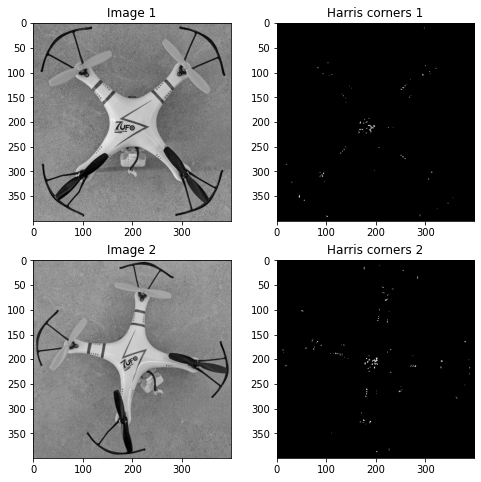

In [4]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(im_1,cmap='gray')
plt.title('Image 1')
plt.subplot(2,2,2)
plt.imshow(kp_1,cmap='gray')
plt.title('Harris corners 1')
plt.subplot(2,2,3)
plt.imshow(im_2,cmap='gray')
plt.title('Image 2')
plt.subplot(2,2,4)
plt.imshow(kp_2,cmap='gray')
plt.title('Harris corners 2')
plt.show()

In [5]:
def get_patch(im,x,y,w=10):
    return im[x-w:x+w,y-w:y+w]

## Types of invariances

First though, let's look at a few different invariances we might need to deal with. We will apply a few affine transformations to the image patch to illustrate this.

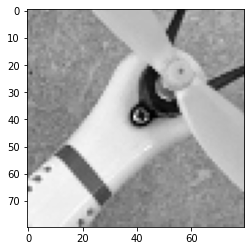

In [6]:
pos_x = kpx_1[20]
pos_y = kpy_1[20]
test_patch = get_patch(im_1,pos_x,pos_y,40)
plt.imshow(test_patch,cmap='gray')
plt.show()

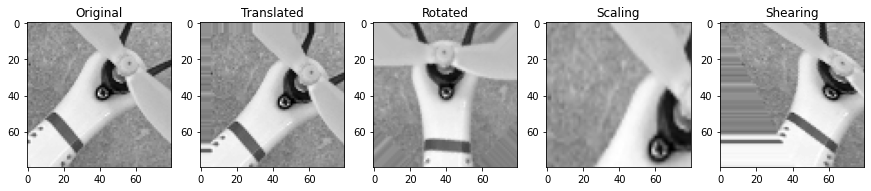

In [7]:
# Translate 5 pixels
M = np.array([[1,0,5.0],[0,1,5.0]])
translated_patch = cv2.warpAffine(test_patch,M,test_patch.shape,borderMode=cv2.BORDER_REPLICATE)

# Rotate 45 degrees
M = cv2.getRotationMatrix2D((test_patch.shape[0]/2,test_patch.shape[1]/2),45,1)
rotated_patch = cv2.warpAffine(test_patch,M,test_patch.shape,borderMode=cv2.BORDER_REPLICATE)

# Scaling
M = np.array([[1.5, 0  , 0],[0,   1.8, 0],[0,   0,   1]])
scaled_patch = cv2.warpPerspective(test_patch,M,(test_patch.shape[0],test_patch.shape[0]),borderMode=cv2.BORDER_REPLICATE)

# Shearing
M = np.array([[1, 0.5, 0],[0, 1  , 0],[0, 0  , 1]])
sheared_patch = cv2.warpPerspective(test_patch,M,test_patch.shape,borderMode=cv2.BORDER_REPLICATE)

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(test_patch,cmap='gray')
plt.title('Original')
plt.subplot(1,5,2)
plt.imshow(translated_patch,cmap='gray')
plt.title('Translated')
plt.subplot(1,5,3)
plt.imshow(rotated_patch,cmap='gray')
plt.title('Rotated')
plt.subplot(1,5,4)
plt.imshow(scaled_patch,cmap='gray')
plt.title('Scaling')
plt.subplot(1,5,5)
plt.imshow(sheared_patch,cmap='gray')
plt.title('Shearing')
plt.show()


These operations illustrate a few of the different appearances we may encounter when trying to match patches across viewpoints. No wonder the SSD error wasn't very good at matching. We need matching algorithms that can cope with these appearance changes.

### Learning from synthetic data

These warping operations - which we will cover in more detail next week when we tackle Homographies, are really useful to generate example images for methods that try to learn from data. From a single image, we can generate many different variations to learn from. This is a common strategy in deep learning approaches, and called data augmentation. As an example, if we were to teach a neural network that this image is a picture of a propeller, we could generate 100s of examples of this image with labels, and have how network learn to be invariant to these appearance variations.

To get a clearer idea of how this might work, let's implement an assymetric feature matching search. We'll build on the patch matching code used last week, and only consider rotation and translation.

In [8]:
# A function to randomly shift and rotate an image patch
def random_warp(patch):
    
    # Translate randomly
    d = 5*np.random.randn()
    M = np.array([[1,0,d],[0,1,d]])
    patch = cv2.warpAffine(patch,M,patch.shape,borderMode=cv2.BORDER_REPLICATE)

    # Rotate randomly
    theta = 30*np.random.randn()
    M = cv2.getRotationMatrix2D((patch.shape[0]/2,patch.shape[1]/2),theta,1)
    patch = cv2.warpAffine(patch,M,patch.shape,borderMode=cv2.BORDER_REPLICATE)
    
    return patch
    
# A function to compute sum of squared distances between patches
def ssd(patch_1,patch_2):
    
    if (patch_1.shape != patch_2.shape): #Ignore patches around the edges 
        return 1e15
    else:
        return np.sum((patch_1-patch_2)**2)
    
# Assymetric feature matching - returns the minimum distance across view variations
def find_minimum_distance_across_viewpoints(patch_1,patch_2,N=100):
    
    min_dist = 1e15
    for j in range(N):
        
        if (patch_1.shape != patch_2.shape): #Ignore patches around the edges 
            continue
        else:
            random_patch_2 = random_warp(patch_2)
            dist = ssd(patch_1,random_patch_2)

            if (dist < min_dist):

                min_dist = dist
            
    return min_dist

# Finds the closest patch to a list of patches, with assymetric
def find_closest_patch(im_to_search, kp_x_to_search, kp_y_to_search, query_patch):
    
    min_dist = 1e15
    min_dist_idx = 0
    # Loop over all corners
    for i in range(len(kp_x_to_search)):
        
        pos_x = kp_x_to_search[i]
        pos_y = kp_y_to_search[i]
        test_patch = get_patch(im_to_search,pos_x,pos_y,w=int(query_patch.shape[0]/2))
        
        # Compare 100 different patch views and return the minimum distance
        dist = find_minimum_distance_across_viewpoints(test_patch,query_patch,N=10)
        
        if dist <= min_dist:
            min_dist = dist
            min_dist_idx = i
            
    pos_x = kp_x_to_search[min_dist_idx]
    pos_y = kp_y_to_search[min_dist_idx]
        
    return get_patch(im_to_search,pos_x,pos_y), min_dist_idx, min_dist    

In [9]:
# Loop over all keypoints in image 2, and find closest match in image 1
match_idxs = []
match_dists = []
for j in range(len(kpx_2)):
    pos_x = kpx_2[j]
    pos_y = kpy_2[j]
    test_patch = get_patch(im_2,pos_x,pos_y)
    best_patch, patch_idx, patch_dist = find_closest_patch(im_1,kpx_1,kpy_1,test_patch)
    match_idxs.append(patch_idx)
    match_dists.append(patch_dist)

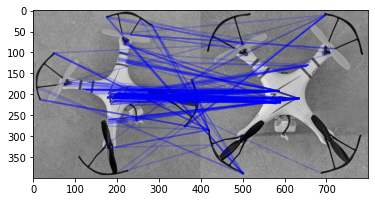

In [10]:
def plot_matches(kpx_1,kpy_1,kpx_2,kpy_2,jump=100):
    plt.plot([kpy_1,kpy_2+jump],[kpx_1,kpx_2],'b',alpha=0.2)

im_both = np.hstack((im_2,im_1)) # Concatenate images
plt.imshow(im_both,cmap='gray')
for j in range(len(match_idxs)):
    x_2 = kpx_2[j]
    y_2 = kpy_2[j]
    
    x_1 = kpx_1[match_idxs[j]]
    y_1 = kpy_1[match_idxs[j]]
    if match_dists[j] < 0.8*max(match_dists): # Only show matches below some distance threshold
        plot_matches(x_2,y_2,x_1,y_1,jump=im_1.shape[0])
plt.show()

Ok, we definitely got more matches than we had last week (quite a few incorrect ones because this drone has a lot of self-similar patches). These additional matches occur because we have added rotational invariance to our feature descriptor.

### Activity 1

- Count the number of loops we used for asymmetric feature matching.
- If there are K1 keypoints in the first image, K2 keypoints in the second image, and N different viewpoint variations, how many distances does the nearest neighbour search need to compute?
- Increase the value of N, what does this do to the speed of the search?
- How could you speed up this search, try to list three strategies from the lecture videos?

## BRIEF - Binary Robust Independent Elementary Features 

The approach above is very slow, and we discussed a number of methods in the lectures to speed this up. Most of these relied on incurring a larger initial or upfront cost to reorganise our data for fast searching, or to train a model (eg. a decision tree) that makes it easier to rapidly search by asking targeted questions about our image patches.

This approach can be problematic for for real-time systems, so let's look at a quick and dirty approach. Let's write a class to implement the basic idea behind BRIEF, which is very very fast. We won't consider assymetric feature matching here, but it's easy to expand to this too.

In [11]:
class BriefDetector:
    
    def __init__(self,width=10,num_tests=64):
        
        # First, generate a random set of coordinate pairs to compare image intensity
        self.coords = np.random.randint(0,width,(num_tests,4))
        
    # We'll return the comparison result, and add some dodgy error handling 
    def binary_comparison(self,patch,coord):
        try:
            return (patch[coord[0],coord[1]] > patch[coord[2],coord[3]])
        except:
            return 0
        
    # Brief builds a code or descriptor for an image patch using a number of test outcomes
    def get_binary_code(self,patch):
        
        code = [self.binary_comparison(patch,self.coords[i,:]) for i in range(self.coords.shape[0])]
        
        return np.array(code)

# We can match these code vectors very quickly, using some neat numpy tricks and a hamming distance
def FastMatching(codes_1, codes_2):
    
        c1 = np.array(codes_im_1)[np.newaxis,:,:] # reshape to 1 x Nkeypoints X descriptor dimension
        c2 = np.array(codes_im_2)[:,np.newaxis,:] # reshape to Nkeypoints x 1 x descriptor dimension
        
        pairwise_hamming_distance = np.sum(c1!=c2,axis=-1) # take advantage of numpy broadcasting
        
        return np.argmin(pairwise_hamming_distance,axis=-1), np.min(pairwise_hamming_distance,axis=-1) #return the location of the minimum distance
        
        

In [12]:
pw = 10
detector = BriefDetector(width=pw*2,num_tests=64)

# extract binary descriptors for each patch
codes_im_1 = [detector.get_binary_code(get_patch(im_1,kpx_1[j],kpy_1[j],pw)) for j in range(len(kpx_1))] 
codes_im_2 = [detector.get_binary_code(get_patch(im_2,kpx_2[j],kpy_2[j],pw)) for j in range(len(kpx_2))]

In [13]:
match_idxs, min_distances = FastMatching(codes_im_1,codes_im_2)

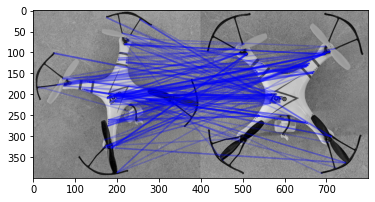

In [14]:
def plot_matches(kpx_1,kpy_1,kpx_2,kpy_2,jump=100):
    plt.plot([kpy_1,kpy_2+jump],[kpx_1,kpx_2],'b',alpha=0.2)

im_both = np.hstack((im_2,im_1)) # Concatenate images
plt.imshow(im_both,cmap='gray')
for j in range(len(match_idxs)):
    x_2 = kpx_2[j]
    y_2 = kpy_2[j]
    
    x_1 = kpx_1[match_idxs[j]]
    y_1 = kpy_1[match_idxs[j]]
    if min_distances[j] < 0.7*min_distances.max(): # Only show matches below some distance threshold
        plot_matches(x_2,y_2,x_1,y_1,jump=im_1.shape[0])
plt.show()

### Activity 2

Modify the code above to change the number of tests used by the BRIEF Detector (the descriptor length) and the patch width. 

How does this change the detection?

Ok, so we now have a very rough and noisy technique that let's us locate a patch in an image. We've used a lot of tools to get this far:

- We've looked at convolutional filters to enhance or suppress unecessary information in an image
- We've covered keypoint and patch representations in images
- We've covered data augmentation and image invariances
- We've encountered some of the computational complexities of search or matching
- We've applied the idea of compressing an image or patch to a vector or descriptor to speed up or simplify matching.

Next week, we will start to look at some geometric properties of cameras, and how we can use keypoint matches to figure out the camera properties. We also encounter a robust model fitting approach that can handle outliers, like the eroneous matches we see above.